## Generating rarefaction curves for the sequencing data
### From https://github.com/joey711/phyloseq/issues/143

In [2]:
# Loading R packages
library(reshape)
library(ggplot2)
library(phyloseq)
library(plyr)
library(dplyr)
library(plotly)
library(wesanderson)
library(breakaway)

Warning message:
“package ‘ggplot2’ was built under R version 3.3.2”
Attaching package: ‘plyr’

The following objects are masked from ‘package:reshape’:

    rename, round_any


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from ‘package:reshape’:

    rename

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
“package ‘plotly’ was built under R version 3.3.2”
Attaching package: ‘plotly’

The following objects are masked from ‘package:plyr’:

    arrange, mutate, rename, summarise

The following object is masked from ‘package:ggplot2’:

    last_plot

The following object is masked from ‘package:reshape’:

    rename

The following object is masked from ‘package:stats’:

    filter

The following object is

In [3]:
# Importing the dataset
ps = import_biom("../../data/Seq_data/QIIME_maxee2/OTU_table/feature-table-metaD-tax2.biom",parseFunction=parse_taxonomy_greengenes, "../../data/Seq_data/QIIME_maxee2/OTU_table/Trees3/fulltree2.rooted.tre")
ps.wb = prune_samples(sample_data(ps)$Project_ID=="WB15", ps)
ps.wb = prune_samples(sample_data(ps.wb)$Org_or_Min %in% c("O","M"), ps.wb)

# Merging lab replicates for analysis
ps.merged = merge_samples(ps.wb, "Sample_ID")

# This sums the OTUs for each sample ID, and averages the sample data
# That's an issue for the non-numeric sample data, so we have to add it back in.
# The code below is probably inefficient, but it works correctly.
names=colnames(sample_data(ps.wb))
notcommonnames = c('Sample_Name','Replicate','Project_ID','Fwd_Primer_Barcode','Rev_Primer_Barcode','Revcomp_Rev_Primer_Barcode')
commonnames = names[(names %in% notcommonnames)]
common_sample_data = sample_data(ps.wb)[ , -which(names(sample_data(ps.wb)) %in% commonnames)]
commonrownames=row.names(sample_data(ps.merged))
common_sample_data2 = common_sample_data[which(common_sample_data$Sample_ID %in% commonrownames),]
common_sample_data2 = common_sample_data2[!duplicated(common_sample_data2$Sample_ID), ]
row.names(common_sample_data2) = common_sample_data2$Sample_ID
sample_data(ps.merged)=common_sample_data2
sample_data(ps.merged)$TotalSeqs = sample_sums(ps.merged)

ps = ps.merged

Warning message in strsplit(msg, "\n"):
“input string 1 is invalid in this locale”Warning message in asMethod(object):
“NAs introduced by coercion”Warning message in asMethod(object):
“NAs introduced by coercion”Warning message in asMethod(object):
“NAs introduced by coercion”Warning message in asMethod(object):
“NAs introduced by coercion”Warning message in asMethod(object):
“NAs introduced by coercion”Warning message in asMethod(object):
“NAs introduced by coercion”Warning message in asMethod(object):
“NAs introduced by coercion”Warning message in asMethod(object):
“NAs introduced by coercion”Warning message in asMethod(object):
“NAs introduced by coercion”Warning message in asMethod(object):
“NAs introduced by coercion”Warning message in asMethod(object):
“NAs introduced by coercion”Warning message in asMethod(object):
“NAs introduced by coercion”Warning message in asMethod(object):
“NAs introduced by coercion”Warning message in asMethod(object):
“NAs introduced by coercion”Warning 

In [4]:
calculate_rarefaction_curves <- function(psdata, measures, depths) {
  require('plyr') # ldply
  require('reshape2') # melt

  estimate_rarified_richness <- function(psdata, measures, depth) {
    if(max(sample_sums(psdata)) < depth) return()
    psdata <- prune_samples(sample_sums(psdata) >= depth, psdata)

    rarified_psdata <- rarefy_even_depth(psdata, depth, verbose = FALSE)

    alpha_diversity <- estimate_richness(rarified_psdata, measures = measures)

    # as.matrix forces the use of melt.array, which includes the Sample names (rownames)
    molten_alpha_diversity <- melt(as.matrix(alpha_diversity), varnames = c('Sample', 'Measure'), value.name = 'Alpha_diversity')

    molten_alpha_diversity
  }

  names(depths) <- depths # this enables automatic addition of the Depth to the output by ldply
  rarefaction_curve_data <- ldply(depths, estimate_rarified_richness, psdata = psdata, measures = measures, .id = 'Depth', .progress = ifelse(interactive(), 'text', 'none'))

  # convert Depth from factor to numeric
  rarefaction_curve_data$Depth <- as.numeric(levels(rarefaction_curve_data$Depth))[rarefaction_curve_data$Depth]

  rarefaction_curve_data
}

In [5]:
rarefaction_curve_data = calculate_rarefaction_curves(ps, c('Observed'), rep(c(1, 100, 500, 1000, 2000, 5000, 10000, 20000), each = 10))
summary(rarefaction_curve_data)

Loading required package: reshape2

Attaching package: ‘reshape2’

The following objects are masked from ‘package:reshape’:

    colsplit, melt, recast



     Depth               Sample         Measure         value      
 Min.   :    1   X15S.NT.19O:  80   Observed:7180   Min.   :  1.0  
 1st Qu.:  100   X15S.NT.20O:  80                   1st Qu.: 65.0  
 Median : 1000   X15S.NT.23O:  80                   Median :159.0  
 Mean   : 3220   X15S.NT.25O:  80                   Mean   :167.3  
 3rd Qu.: 5000   X15S.NT.30M:  80                   3rd Qu.:233.0  
 Max.   :20000   X15S.NT.31O:  80                   Max.   :912.0  
                 (Other)    :6700                                  

In [6]:
rarefaction_curve_data_summary = ddply(rarefaction_curve_data, c('Depth', 'Sample', 'Measure'), summarise, alpha_diversity_mean = mean(value), alpha_diversity_sd = sd(value))

In [7]:
sample_names(ps) = paste("X",sample_names(ps) ,sep="")
sample_names(ps) = gsub("-",".", sample_names(ps))

In [8]:
rarefaction_curve_data_summary_verbose = merge(rarefaction_curve_data_summary, data.frame(sample_data(ps)), by.x = 'Sample', by.y = 'row.names')

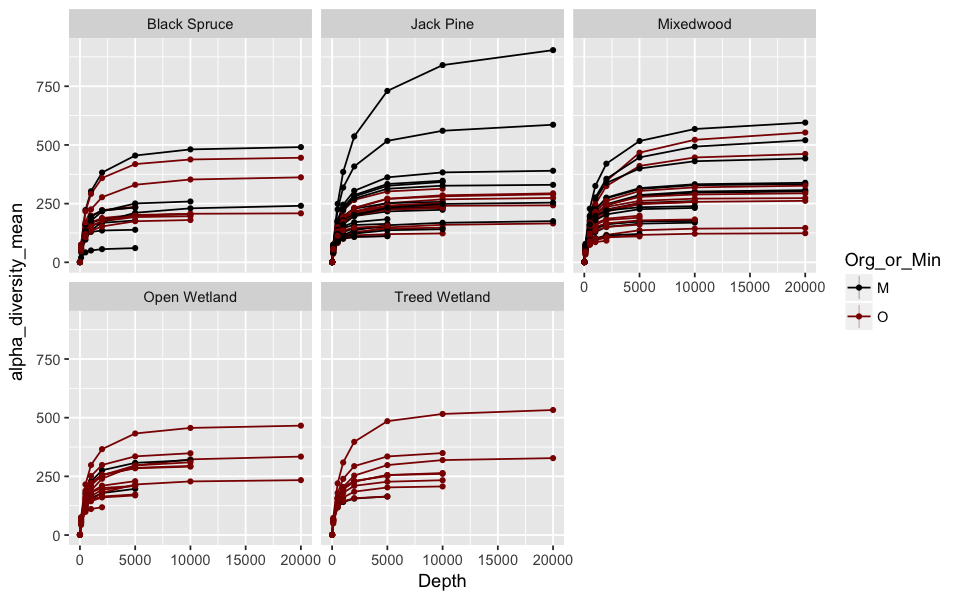

In [9]:
options(repr.plot.width=8, repr.plot.height=5)
ggplot(
  data = rarefaction_curve_data_summary_verbose,
  mapping = aes(
    x = Depth,
    y = alpha_diversity_mean,
    ymin = alpha_diversity_mean - alpha_diversity_sd,
    ymax = alpha_diversity_mean + alpha_diversity_sd,
    colour = Org_or_Min,
    group = Sample
  )
) + geom_line(
) + scale_colour_manual(values=c("black","darkred")
) + geom_pointrange(size=0.1
) + facet_wrap(facets = ~ Veg_Comm) + scale_x_continuous(limits = c(0, 20000))

## Calculating richness estimates with Betta

In [10]:
ps = import_biom("../../data/Seq_data/QIIME_maxee2/OTU_table/feature-table-metaD-tax2.biom",parseFunction=parse_taxonomy_greengenes, "../../data/Seq_data/QIIME_maxee2/OTU_table/Trees3/fulltree2.rooted.tre")
ps.wb = prune_samples(sample_data(ps)$Project_ID=="WB15", ps)
ps.wb = prune_samples(sample_data(ps.wb)$Org_or_Min %in% c("O","M"), ps.wb)

# Merging lab replicates for analysis
ps.merged = merge_samples(ps.wb, "Sample_ID")

# This sums the OTUs for each sample ID, and averages the sample data
# That's an issue for the non-numeric sample data, so we have to add it back in.
# The code below is probably inefficient, but it works correctly.
names=colnames(sample_data(ps.wb))
notcommonnames = c('Sample_Name','Replicate','Project_ID','Fwd_Primer_Barcode','Rev_Primer_Barcode','Revcomp_Rev_Primer_Barcode')
commonnames = names[(names %in% notcommonnames)]
common_sample_data = sample_data(ps.wb)[ , -which(names(sample_data(ps.wb)) %in% commonnames)]
commonrownames=row.names(sample_data(ps.merged))
common_sample_data2 = common_sample_data[which(common_sample_data$Sample_ID %in% commonrownames),]
common_sample_data2 = common_sample_data2[!duplicated(common_sample_data2$Sample_ID), ]
row.names(common_sample_data2) = common_sample_data2$Sample_ID
sample_data(ps.merged)=common_sample_data2
sample_data(ps.merged)$TotalSeqs = sample_sums(ps.merged)

ps = ps.merged

Warning message in strsplit(msg, "\n"):
“input string 1 is invalid in this locale”Warning message in asMethod(object):
“NAs introduced by coercion”Warning message in asMethod(object):
“NAs introduced by coercion”Warning message in asMethod(object):
“NAs introduced by coercion”Warning message in asMethod(object):
“NAs introduced by coercion”Warning message in asMethod(object):
“NAs introduced by coercion”Warning message in asMethod(object):
“NAs introduced by coercion”Warning message in asMethod(object):
“NAs introduced by coercion”Warning message in asMethod(object):
“NAs introduced by coercion”Warning message in asMethod(object):
“NAs introduced by coercion”Warning message in asMethod(object):
“NAs introduced by coercion”Warning message in asMethod(object):
“NAs introduced by coercion”Warning message in asMethod(object):
“NAs introduced by coercion”Warning message in asMethod(object):
“NAs introduced by coercion”Warning message in asMethod(object):
“NAs introduced by coercion”Warning 

In [11]:
FreqTableGenerator = function(Sample){
    df = data.frame(t(otu_table(ps))[,Sample])
    # Grab the OTU table
    colnames(df)="Frequency"
    # Add a column for the frequencies of the OTUs
    df = df %>%
        group_by(Frequency)%>%
        summarize(nOTUs=n())%>%
        arrange(Frequency)
    # Summarize the total OTUs that are present at each frequency
    df = df[df$Frequency>1,]
    # Cut out the 0 and 1 frequencies (because dada2 trimmed singletons)
    colnames(df)=NULL
    # Omit column names
    df = as.matrix(df)
    # Spit out a nice matrix
    df
}
# Generates the frequency table summary needed by breakaway

In [12]:
Samples = sample_names(ps)

In [33]:
report = data.frame(name="",Richness_estimate="",Richness_stderr="",Richness_model="")
breakawayrunner = function(SampleName){
    df = FreqTableGenerator(SampleName)
    #print(head(df))
    #print(SampleName)
    #print(sum(df[,1]*df[,2]))
    if(df[1,1]==2 & (sum(df[1:6,1])==sum(c(2:7)))){
        # First, check that the first frequency count is, indeed, 2,
        # and there are at least 6 consecutive counts (could actually just do this test)
            m = breakaway_nof1(df, answers=TRUE, plot=FALSE, print=FALSE)
        # Run breakaway for the no singletons data
            Richness_model = m$name
            Richness_estimate = m$est
            Richness_stderr = m$seest
            name = SampleName
        # Grab the outputs
            report = data.frame(name,Richness_estimate,Richness_stderr,Richness_model)
        # Generate a report
    } else {
        name = SampleName
        report=data.frame(name)
        # If breakaway isn't going to work anyway, just spit out the name (and NAs)
        }

    report

}

In [34]:
Reports = mdply(Samples,breakawayrunner)
head(Reports)

X1,name,Richness_estimate,Richness_stderr,Richness_model
1,15S-NT-19O,540.5956,2.322002,WLRM
2,15S-NT-20O,359.1059,7.635401,model_1_1
3,15S-NT-21M,324.6704,2.566158,WLRM
4,15S-NT-21O,NA,NA,NA
5,15S-NT-22M,187.9188,2.187871,WLRM
6,15S-NT-22O,239.6798,1.977938,WLRM


In [17]:
Report_Summary = Reports %>%
    group_by(Richness_model)%>%
    summarize(n())
Report_Summary
# How many of each sample fit each model type

Richness_model,n()
WLRM,49
model_1_1,20
,17
model_2_1,2
model_4_3,1
model_1_0,11
model_2_2,2


In [35]:
sample_data(ps)[,colnames(Reports)[3:5]]=Reports[,3:5]

In [36]:
mdf = sample_data(ps)

Warning message:
“Removed 17 rows containing missing values (geom_point).”Warning message:
“Removed 21 rows containing missing values (geom_errorbar).”

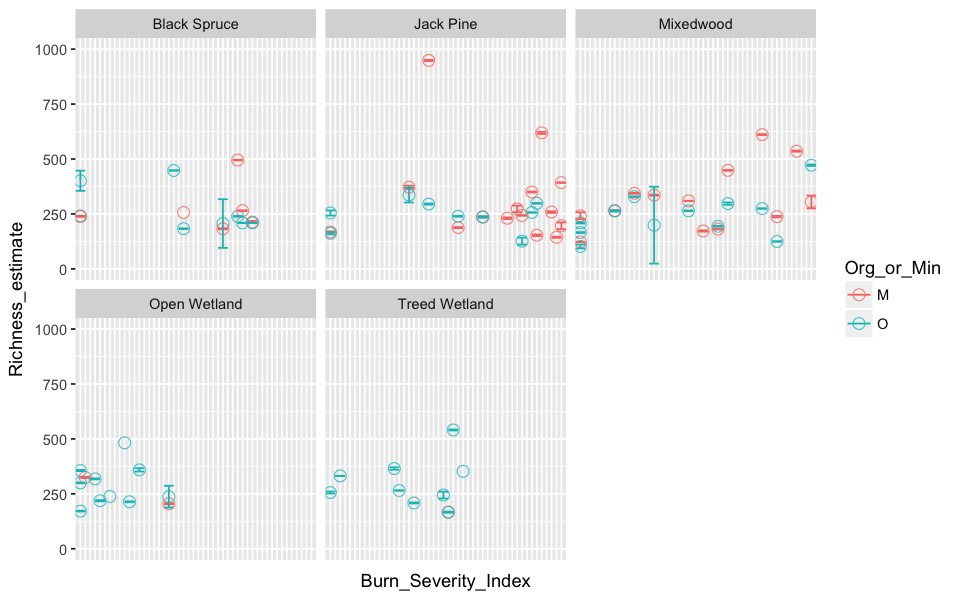

In [92]:
p = ggplot(mdf, aes(Burn_Severity_Index, Richness_estimate, colour=Org_or_Min))
p = p + geom_point(size=3,pch=21, alpha=0.75)
p = p + geom_errorbar(aes(ymin = Richness_estimate-Richness_stderr, ymax = Richness_estimate+Richness_stderr), width = 2)
p = p + ylim(0,1000)
p = p + facet_wrap(~Veg_Comm)
p = p + theme(axis.text.x=element_blank()
              ,axis.ticks.x=element_blank()
             #,panel.grid=element_blank()
             #,panel.background=element_blank()
             )
p